In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
samples_path = "/content/drive/MyDrive/Gav/BolADRB3.xlsx"
df = pd.read_excel(samples_path)
df.head()

,Number,Allele1,Allele2,CD4,CD8,CD4CD8,CD21,SN,SP
0,72,*1201,*20012,8.96,9.83,0.9,7.53,0,1
1,56,*0101,*0101,50.80,20.52,2.5,0.50,0,1
2,96,*0601,*1101,31.20,38.40,0.8,5.04,1,0
3,95,*1101,*1802,15.59,20.90,0.7,14.57,0,1
4,94,*1201,*2704,49.95,16.36,3.1,7.25,1,0


In [ ]:
df = df.reindex(columns=['SN', 'SP', 'Allele1', 'Allele2', 'CD4', 'CD8', 'CD4CD8', 'CD21'])
cds = df.iloc[:, 4:8].to_numpy()

In [ ]:
print(df.head())
print(df.iloc[0:5, 3].values)

   SN  SP Allele1 Allele2    CD4    CD8  CD4CD8   CD21
0   0   1   *1201  *20012   8.96   9.83     0.9   7.53
1   0   1   *0101   *0101  50.80  20.52     2.5   0.50
2   1   0   *0601   *1101  31.20  38.40     0.8   5.04
3   0   1   *1101   *1802  15.59  20.90     0.7  14.57
4   1   0   *1201   *2704  49.95  16.36     3.1   7.25
['*20012' '*0101' '*1101' '*1802' '*2704']


Text(0.5, 1.0, 'Raw data')

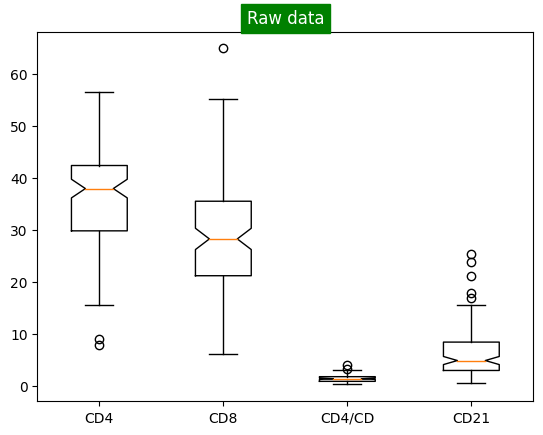

In [ ]:
plt.figure('Raw data')
plt.boxplot(cds, notch = 'True', labels = ['CD4', 'CD8', 'CD4/CD', 'CD21'])
plt.title('Raw data', color = 'white', backgroundcolor = 'green')

In [ ]:
df_minmax = df.copy()
scaler = preprocessing.MinMaxScaler()
df_minmax.iloc[:,4:8] = scaler.fit_transform(df_minmax.iloc[:,4:8].to_numpy())

In [ ]:
plt.figure('Scaled-MinMax')
plt.boxplot(df_minmax.iloc[:,4:8], notch = 'True', labels = ['CD4', 'CD8', 'CD4/CD', 'CD21'])
plt.title('Scaled-MinMax', color = 'white', backgroundcolor = 'green')

In [ ]:
df_maxabs = df.copy()
scaler = preprocessing.MaxAbsScaler()
df_maxabs.iloc[:,4:8] = scaler.fit_transform(df_maxabs.iloc[:,4:8].to_numpy())

In [ ]:
plt.figure('Scaled-MaxAbs')
plt.boxplot(df_maxabs.iloc[:,4:8], notch = 'True', labels = ['CD4', 'CD8', 'CD4/CD', 'CD21'])
plt.title('Scaled-MaxAbs', color = 'white', backgroundcolor = 'green')

In [ ]:
df_standard = df.copy()
scaler = preprocessing.StandardScaler()
df_standard.iloc[:,4:8] = scaler.fit_transform(df_standard.iloc[:,4:8].to_numpy())

In [ ]:
plt.figure('Scaled-Standard')
ax = plt.boxplot(df_standard.iloc[:,4:8], notch = 'True', labels = ['CD4', 'CD8', 'CD4/CD', 'CD21'])
plt.title('Scaled-Standard', color = 'white', backgroundcolor = 'green')

In [ ]:
df_robust = df.copy()
scaler = preprocessing.RobustScaler()
df_robust.iloc[:,4:8] = scaler.fit_transform(df_robust.iloc[:,4:8].to_numpy())

Text(0.5, 1.0, 'Scaled-Robust')

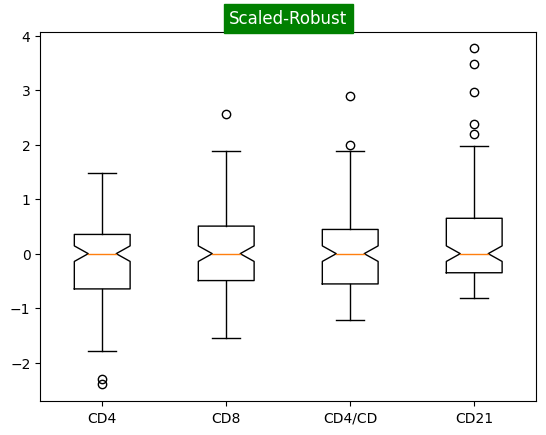

In [ ]:
plt.figure('Scaled-Robust')
plt.boxplot(df_robust.iloc[:,4:8], notch = 'True', labels = ['CD4', 'CD8', 'CD4/CD', 'CD21'])
plt.title('Scaled-Robust', color = 'white', backgroundcolor = 'green')

In [ ]:
# df_chosen = df.copy()
# df_chosen = df_minmax.copy()
# df_chosen = df_maxabs.copy()
# df_chosen = df_standard.copy()
df_chosen = df_robust.copy()

In [ ]:
df_chosen = df_chosen.join(
  pd.get_dummies(df_chosen.filter(like='Allele').stack())
    .groupby(level=0).max()
  ).drop(['Allele1', 'Allele2'], axis=1)

In [ ]:
df_chosen

,SN,SP,CD4,CD8,CD4CD8,CD21,*0101,*0201,*0301,*0303,...,*2709,*3001,*3201,*3202,*3401,*3501,*4201,*4301,*6801,*6901
0,0,1,-2.308367,-1.287911,-0.555556,0.482569,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1.025498,-0.540881,1.222222,-0.807339,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,-0.536255,0.708595,-0.666667,0.025688,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,-1.780080,-0.514326,-0.777778,1.774312,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0.957769,-0.831586,1.888889,0.431193,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,1,0,0.042231,-0.517820,0.444444,1.170642,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,1,0,0.019920,-0.502446,0.444444,0.497248,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,1,0,-0.781673,0.037037,-0.444444,1.104587,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
119,0,1,-1.201594,1.043326,-1.000000,1.790826,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
mismatch = (df_chosen.iloc[:, 0].values != df_chosen.iloc[:, 1].values)
print(sum(mismatch))

121


In [ ]:
X = df_chosen.iloc[:, 2:].values
Y = df_chosen.iloc[:, 1].values

x_train, x_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=42)

x_train_n = torch.FloatTensor(x_train[:, :4])
x_train_c = torch.FloatTensor(x_train[:, 4:])
y_train = torch.FloatTensor(y_train)
x_test_n = torch.FloatTensor(x_test[:, :4])
x_test_c = torch.FloatTensor(x_test[:, 4:])
y_test = torch.FloatTensor(y_test)

In [ ]:
print(y_test.shape)
print(torch.sum(y_test))
print(y_train.shape)
print(x_train_n.shape)
print(x_train_c.shape)

torch.Size([25])
tensor(5.)
torch.Size([96])
torch.Size([96, 4])
torch.Size([96, 36])


In [ ]:
class NeuralNetMerged(nn.Module):
    def __init__(self, in_features_num=4, in_features_cat=36, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features_num,
                             out_features=12)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(in_features=in_features_cat,
                             out_features=18)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(in_features=30,
                             out_features=out_features)


    def forward(self, X_num, X_cat):
        X_num = self.act1(self.fc1(X_num))
        X_num = self.dropout1(X_num)
        X_cat = self.act2(self.fc2(X_cat))
        X_cat = self.dropout1(X_cat)
        X = torch.cat((X_num, X_cat), dim = 1)
        X = F.sigmoid(self.fc3(X))
        return X

In [ ]:
class ModelHandler2():
  def __init__(self, model, epochs, learning_rate):
    self.model = model
    self.epochs = epochs
    # self.criterion =  nn.CrossEntropyLoss()
    # self.criterion =  nn.BCELoss()
    self.criterion =  nn.MSELoss()
    self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  def train(self, x_train_n, x_train_c, y_train):
    losses = torch.zeros((self.epochs, 1))
    correct, total = 0, 0
    y_pred_vec = torch.zeros((self.epochs, y_train.shape[0]))
    for i in tqdm(range(self.epochs)):
      y_pred = self.model(x_train_n, x_train_c)
      y_pred = torch.squeeze(y_pred)
      self.optimizer.zero_grad()
      loss = self.criterion(y_pred, y_train)
      losses[i] = loss
      loss.backward()
      self.optimizer.step()
      # print(y_pred.shape)
      # print(y_pred_vec.shape)
      y_pred_vec[i, :] = y_pred
      predicted = torch.round(y_pred)
    return losses, predicted, y_pred_vec


  def test(self, x_test_n, x_test_c, y_test):
    self.model.eval()
    with torch.no_grad():
      y_pred = self.model(x_test_n, x_test_c)
      y_pred = torch.squeeze(y_pred)
      predicted = torch.round(y_pred)
    return predicted, y_pred

  def metricCalculator(self, y_true, y_hat):
      acc = accuracy_score(y_true, y_hat)
      pr, rec, f1, _ = precision_recall_fscore_support(y_true, y_hat, average = 'binary')
      print(rec.shape)
      return acc, pr, rec, f1

In [ ]:
def plot_loss_metrics(train_loss, train_acc, train_pr, train_rec, train_f1):
  epochs = len(train_loss)
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(2, 3)
  ax1.plot(np.arange(epochs), train_loss, label='Training Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Loss vs. Epochs')
  ax1.legend()

  ax2.plot(np.arange(epochs), train_acc, label='Training Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Accuracy vs. Epochs')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

  ax3.plot(np.arange(epochs), train_pr, label='Training Precision')
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('Precision')
  ax3.set_title('Precision vs. Epochs')
  ax3.legend()
  fig.set_size_inches(15.5, 5.5)

  ax4.plot(np.arange(epochs), train_rec, label='Training Recall')
  ax4.set_xlabel('Epochs')
  ax4.set_ylabel('Recall')
  ax4.set_title('Recall vs. Epochs')
  ax4.legend()
  fig.set_size_inches(15.5, 5.5)

  ax5.plot(np.arange(epochs), train_f1, label='Training F1')
  ax5.set_xlabel('Epochs')
  ax5.set_ylabel('F1')
  ax5.set_title('F1 vs. Epochs')
  ax5.legend()
  fig.set_size_inches(15.5, 5.5)

  plt.show()

In [ ]:
model2 = NeuralNetMerged(4, 36, 1)
handler = ModelHandler2(model2, 400, 0.01)
train_loss, predicted_vec, y_pred_vec = handler.train(x_train_n, x_train_c, y_train)
train_acc, train_pr, train_rec, train_f1 = handler.metricCalculator(y_train.detach().numpy(), predicted_vec.detach().numpy())
# print(train_acc[-1])

  0%|          | 0/400 [00:00<?, ?it/s]

()


Raw:

avg of last 101: 0.7908333333333333

final: 0.8020833333333334

    [[17  3]
     [ 2  3]]

    (0.5, 0.6, 0.5454545454545454, None)

\\
Minmax:

avg of last 101: 0.8665624999999999

final: 0.8854166666666666

    [[18    2]
     [ 3    2 ]]

    (0.5, 0.4, 0.4444444444444445, None)
\\
MaxAbs:

avg of last 101: 0.7908333333333333

final: 0.8020833333333334

    [[20    0]
     [ 4    1 ]]

    (0.5, 0.4, 0.4444444444444445, None)
\\
Standard:

avg of last 101: 0.7908333333333333

final: 0.8020833333333334

    [[15  5]
     [ 2  3]]

    (0.375, 0.6, 0.4615384615384615, None)
\\
Robust:

avg of last 101: 0.7908333333333333

final: 0.8020833333333334

    [[18  2]
     [ 2  3]]

    (0.6, 0.6, 0.6, None)

ValueError: ignored

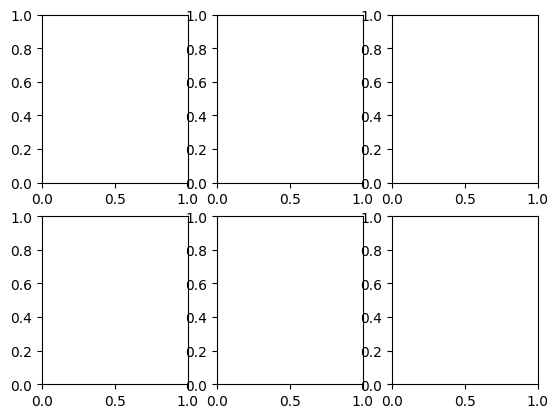

In [ ]:
# print(np.mean(acc[-100:]))
# plot_loss_accuracy(torch.tensor(loss), acc)
plot_loss_metrics(train_loss, train_acc, train_pr, train_rec, train_f1)

In [ ]:
predicted, y_pred = handler.test(x_test_n, x_test_c, y_test)
# print("avg = None :", precision_recall_fscore_support(y_test, predicted))
# print("avg = weighted :", precision_recall_fscore_support(y_test, predicted, average = 'weighted'))
print("avg = binary :", precision_recall_fscore_support(y_test, predicted, average = 'binary')) # This is the accurate one for us
# print("avg = micro :", precision_recall_fscore_support(y_test, predicted, average = 'micro'))
print(accuracy_score(y_test, predicted))

avg = binary : (0.4, 0.4, 0.4000000000000001, None)
0.76


In [ ]:
print(confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])) # (tn, fp, fn, tp)
print(confusion_matrix(y_test, predicted))

[[0 2]
 [1 1]]
[[17  3]
 [ 3  2]]


In [ ]:
print(19/25) # acc = (tp + tf) / (tn+fp+fn+tp)
print(1/3) # precision = tp / (tp + fp)
print(1/5) # recall = tp / (tp + fn)

0.76
0.3333333333333333
0.2


In [ ]:
print(y_pred)
print(predicted)
print(y_test)

tensor([3.4270e-04, 1.8094e-01, 3.3317e-03, 5.5606e-04, 7.2039e-01, 4.8218e-02,
        1.4530e-02, 8.3840e-01, 6.1651e-01, 9.5863e-03, 9.0639e-02, 1.3309e-02,
        9.8959e-01, 4.6892e-01, 1.1127e-02, 9.0197e-01, 2.3354e-01, 3.4617e-03,
        1.1542e-01, 2.6371e-03, 8.0501e-04, 1.3753e-02, 3.0990e-01, 3.3146e-02,
        3.8266e-02])
tensor([0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 0.])


In [ ]:
print(y_pred_train)
print(predicted_train)
print(y_train)
print(y_train - predicted_train)

tensor([5.5761e-01, 6.2514e-05, 6.4782e-01, 1.0993e-02, 5.0000e-01, 6.2573e-05,
        2.6204e-05, 5.0000e-01, 1.1675e-07, 3.8183e-07, 5.0000e-01, 5.2468e-01,
        3.4097e-01, 5.0000e-01, 9.9193e-01, 7.4466e-01, 6.1052e-06, 7.0956e-02,
        4.7277e-01, 3.5975e-01, 5.0000e-01, 9.2810e-01, 4.0253e-07, 1.0479e-02,
        5.0000e-01, 3.7864e-02, 7.8181e-09, 2.5808e-04, 2.6944e-05, 1.6284e-01,
        2.4310e-03, 4.3476e-07, 5.0000e-01, 2.0155e-05, 2.7491e-02, 2.7362e-01,
        5.0000e-01, 5.0000e-01, 4.6771e-01, 6.7656e-01, 8.3557e-01, 5.0000e-01,
        5.0000e-01, 9.9996e-01, 1.8179e-01, 5.0000e-01, 7.7508e-01, 2.0263e-01,
        7.8061e-01, 5.6394e-01, 5.0745e-01, 3.0886e-02, 7.7843e-04, 5.0000e-01,
        8.9021e-02, 9.5270e-02, 9.0072e-01, 5.0000e-01, 4.1875e-11, 6.6305e-02,
        1.3705e-05, 5.0000e-01, 5.3262e-01, 3.5418e-01, 5.0000e-01, 5.0000e-01,
        5.0000e-01, 6.0840e-06, 4.8080e-04, 9.4080e-02, 2.6035e-04, 7.0908e-08,
        5.0000e-01, 5.0000e-01, 9.9572e-

In [ ]:
(y_train - predicted_train)*(y_pred_train)

tensor([ 0.0000,  0.0000, -0.6478,  0.0000,  0.5000,  0.0000,  0.0000,  0.5000,
         0.0000,  0.0000,  0.5000, -0.5247,  0.0000,  0.5000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1628,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5000,  0.4677,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000, -0.5639, -0.5075,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.5000, -0.5326,  0.0000,
         0.5000,  0.5000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.2624,  0.0000,  0.0000,  0.0000],
       grad_fn=<MulBackward0>)

In [ ]:
print(precision_recall_fscore_support(y_train, torch.tensor(predicted_train), average='weighted'))
print(accuracy_score(torch.tensor(y_train), torch.tensor(predicted_train)))

### OLD BS

In [ ]:
X = df_chosen.iloc[:, 2:].values
Y = df_chosen.iloc[:, 1].values

x_train, x_test, y_train, y_test = train_test_split(X, Y,  test_size=0.2, random_state=42)

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, in_features, out_features=2):
        super().__init__()
        self.fc1 = nn.Linear(in_features=in_features,
                             out_features=84)
        # self.fc2 = nn.Linear(in_features=84,
        #                      out_features=84)
        self.fc3 = nn.Linear(in_features=84,
                             out_features=out_features)


    def forward(self, X):
        X = F.relu(self.fc1(X))
        # X = F.relu(self.fc2(X))
        X = F.sigmoid(self.fc3(X))
        return X

In [ ]:
class ModelHandler():
  def __init__(self, model, epochs, learning_rate):
    self.model = model
    self.epochs = epochs
    # self.criterion =  nn.CrossEntropyLoss()
    self.criterion =  nn.BCELoss()
    self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


  def train(self, x_train, y_train):
    losses, acc = [], []
    correct, total = 0, 0
    for i in tqdm(range(self.epochs)):
      y_pred = self.model(x_train)
      y_pred = torch.squeeze(y_pred)
      # print(y_pred)
      # print(y_pred.shape, y_train.shape)
      self.optimizer.zero_grad()
      loss = self.criterion(y_pred, y_train)
      loss.backward()
      self.optimizer.step()
      losses.append(loss)

    #   _, predicted = torch.max(y_pred, 1)
      predicted = torch.round(y_pred)
      total += y_train.size(0)
      correct += (predicted == y_train).sum().item()
      acc.append(correct/total)

    return losses, acc


  def test(self, x_test, y_test):
    # test_loss, test_acc = 0, 0

    self.model.eval()
    # correct, total = 0, 0
    with torch.no_grad():
      y_pred = self.model(x_test)
      predicted = torch.round(y_pred)
    #   _, predicted = torch.max(y_pred, 1)
    # total += y_test.size(0)
    # correct += (predicted == y_test).sum().item()

    # test_acc = correct/total

    return predicted, y_pred

In [ ]:
model = NeuralNet(40, 1)
handler = ModelHandler(model, 150, 0.01)
loss, acc = handler.train(x_train, y_train)